In [1]:
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl', context='notebook', ticks=True, grid=False, figsize=(10, 6))

In [2]:
from IPython.display import display, Markdown
from tqdm.notebook import tqdm

import random
import requests
import re
from copy import copy
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from gensim.models import Word2Vec, FastText

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

___

## Load and Merge

In [4]:
main_df = pd.read_pickle("data/main_df.pickle")

In [5]:
ingredient_df = pd.read_excel("data/ingredient_table.xlsx")
ingredient_df = ingredient_df[['제품명', '업체명', '주성분', '품목기준코드']].copy()

In [6]:
main_df['itemseq'] = main_df['itemseq'].astype(int)
merged_df = pd.merge(main_df, ingredient_df, left_on='itemseq', right_on='품목기준코드')

In [7]:
merged_df = merged_df[['itemname', 'entpname', 'efcyqesitm', 'usemethodqesitm', 'atpnqesitm',
       'itemseq', '주성분']]

merged_df.rename(columns={'주성분': 'ingredient'}, inplace=True)

In [8]:
merged_df.head()

,itemname,entpname,efcyqesitm,usemethodqesitm,atpnqesitm,itemseq,ingredient
0,활명수,동화약품(주),"<p>이 약은 식욕감퇴(식욕부진), 위부팽만감, 소화불량, 과식, 체함, 구역, 구...","<p>만 15세 이상 및 성인은 1회 1병(75 mL), 만 11세이상~만 15세미...",<p>만 3개월 미만의 젖먹이는 이 약을 복용하지 마십시오.</p>\n\n<p>이 ...,195700020,"건강,육두구,후박,진피,창출,현호색,L-멘톨,육계,정향,아선약,고추틴크"
1,신신티눈고(살리실산반창고)(수출명:SINSINCORNPLASTER),신신제약(주),"<p>이 약은 티눈, 못(굳은살), 사마귀에 사용합니다. </p>\n",<p>이형지로부터 벗겨 이 약제면을 환부(질환 부위)에 대고 테이프로 고정하고 2~...,"<p>이 약에 과민증 환자, 당뇨병, 혈액순환장애 환자는 이 약을 사용하지 마십시오...",195900034,살리실산
2,아네모정,삼진제약(주),"<p>이 약은 위산과다, 속쓰림, 위부불쾌감, 위부팽만감, 체함, 구역, 구토, 위...","<p>성인 1회 2정, 1일 3회 식간(식사와 식사때 사이) 및 취침시에 복용합니다...","<p>투석요법을 받고 있는 환자, 수유부, 만 7세 이하의 어린이, 갈락토오스 불내...",195900043,"탄산마그네슘,탄산수소나트륨,침강탄산칼슘,건조수산화알루미늄겔,스코폴리아엑스10배산"
3,타치온정50밀리그램(글루타티온(환원형)),동아제약(주),"<p>이 약은 약물중독, 자가중독에 사용합니다.</p>","<p>성인은 1회 1~2정(50~100 mg), 1일 1~3회 복용합니다.</p><...",,197100015,글루타티온(환원형)
4,겔포스현탁액(인산알루미늄겔),보령제약(주),"<p>이 약은 위.십이지장 궤양, 위염, 위산과다(속쓰림, 위통, 구역, 구토)의 ...","<p>성인은 1회 1포, 1일 3~4회 식간(식사때와 식사때 사이) 및 취침시 복용...","<p>이 약을 복용하기 전에 신장장애, 변비 환자는 의사 또는 약사와 상의하십시오....",197400207,"콜로이드성인산알루미늄,인산알루미늄겔"


___

## Preprocess the feature

In [9]:
def parser1(x) : 
    parsed = re.sub("\<.{,5}\>|\n|\xa0","",x)
    parsed = parsed.replace("·",',').replace("ㆍ",',')
    
    for _ in range(3) : 
        parsed = parser2(parsed)
        
    return re.sub("이 약은\s*|에 사용합니다.", '', parsed)

def parser2(data) : 
    return re.sub('\([\w\s\,]+\)','', data)

def symptom_parse(x) : 
    parsed = parser1(x)
    parsed = re.sub("([A-Z]{1}[1-9]{,1})\,", r'\g<1> &', parsed)
    parsed = parsed.replace("(",'').replace(")",'')
    return parsed

In [10]:
merged_df['symptom'] = merged_df.efcyqesitm.copy().map(symptom_parse)
merged_df['ingredient'] = merged_df.copy().ingredient.map(parser2).str.replace(" ",'')

prep_caution = list(map(lambda x : re.sub("\<.{,5}\>|\n|\xa0","",x), merged_df.atpnqesitm.copy()))
prep_caution = list(map(lambda x : re.sub('[^가-힣\s0-9]',' ', x), prep_caution))
merged_df['caution'] = prep_caution

prep_df = merged_df[['itemname', 'entpname', 'ingredient', 'symptom', 'caution']].copy()

In [11]:
prep_df['splitted_ingredient'] = prep_df.ingredient.str.split(",")
prep_df['splitted_symptom'] = prep_df.symptom.str.split(",").map(lambda x : list(map(lambda i : i.strip(), x)))
prep_df['tokenized_caution'] = list(map(lambda x : word_tokenize(x), prep_caution))

train_df = prep_df.drop_duplicates(['entpname', 'ingredient', 'symptom'])
train_df.shape, prep_df.shape

((4214, 8), (4470, 8))

In [12]:
mem = list()

for row in tqdm(train_df[['splitted_ingredient', 'splitted_symptom']].values) : 
    tmp = list()
    for i in row[0] : 
        for j in row[1] : 
            tmp.append([i,j])            
    mat = np.array(tmp)
    mem.append(mat)
    
data = np.vstack(mem)
data.shape

  0%|          | 0/4214 [00:00<?, ?it/s]

(123847, 2)

___

## Train the model
- pre-train the individual feature using fast-text
- learn projection model name Ingre2Symp model using skip-gram similar logic

1. pretrain

In [13]:
%%time

def augmentation(series, iters=5) : 
    mem = list()
    for _ in range(iters) : 
        tmp = series.map(lambda x : sorted(x, key=lambda k: random.random()))
        mem.append(tmp)
    train = pd.concat(mem, ignore_index=True)
    return train

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 18.1 µs


In [14]:
symptom_w2v = FastText(augmentation(train_df.splitted_symptom).tolist(), vector_size=20, epochs=5*2)
ingre_w2v = FastText(augmentation(train_df.splitted_ingredient).tolist(), vector_size=20, epochs=5*2)
caut_w2v = FastText(train_df.tokenized_caution.tolist(), vector_size=50, epochs=5*1)

2. Indexing to train the torch model

In [15]:
ingre_lemma_dict = {val:idx for idx, val in enumerate(ingre_w2v.wv.index_to_key)}
symp_lemma_dict = {val:idx for idx, val in enumerate(symptom_w2v.wv.index_to_key)}

indexed = np.stack([list(map(lambda x : ingre_lemma_dict.get(x), data[:,0])), list(map(lambda x : symp_lemma_dict.get(x), data[:,1]))]).T
indexed = indexed[np.isfinite(indexed).all(1)]
np.random.shuffle(indexed)

In [16]:
ingre_emb = np.random.random(size=(len(ingre_lemma_dict), ingre_w2v.wv.vector_size))
symp_emb = np.random.random(size=(len(symp_lemma_dict), symptom_w2v.wv.vector_size))

for word, wi in ingre_lemma_dict.items() : 
    ingre_emb[wi] = ingre_w2v.wv.get_vector(word)
    
for word, wi in symp_lemma_dict.items() : 
    symp_emb[wi] = symptom_w2v.wv.get_vector(word)
    
ingre_emb = torch.tensor(ingre_emb)
symp_emb = torch.tensor(symp_emb)

3. modeling

### simple linear projection layer
- 논문 참조 : [Exploiting Similarities among Languages for Machine Translation](https://arxiv.org/pdf/1309.4168.pdf)
- ingredient 와 symptom feature 는 서로를 label 로 사용될 수 있기 때문에 각 vector space 를 projection 을 통해 communicate 하게 만든다. 이는 dictionary form 의 bi-lingual word embedding 학습과 유사한 form 으로 해석될 수 있다.
- 논문에서는 projection layer $W_{L}$ 만 학습하는데 그 이유는 개별 embedding vector 가 well pre-trained 되었다고 가정하기 때문이다. 난 projection layer 를 사용하는 것이 아닌, 더 나은 embedding 을 학습하길 바라므로, 각 embedding layer 까지 학습에 포함시킨다. 

## Note

우리는 이에서 fasttext 를 통해 ingredient 와 symptom feature 에 대한 embedding 을 만들어두었었다. 실제로 해당 embedding 이 각 feature 의 성질과 서로를 설명하는 능력이 있다면, fasttext 를 통한 pretrained embedding 으로 initialization 을 했을 때, 모델 성능이 더 좋을 것이다. 이를 비교함으로써 fasttext+augmentation 방법론의 실효성을 확인해본다. 

In [111]:
class Ingre2Symp(nn.Module) : 
    def __init__(self, ingre_vocab_size, symp_vocab_size, hidden_dim, ingre_pretrained=None, symp_pretrained=None) :
        super().__init__()
        
        if ingre_pretrained is not None :
            self.encoder1 = nn.Embedding.from_pretrained(ingre_pretrained, freeze=False)
        else : 
            self.encoder1 = nn.Embedding(ingre_vocab_size, hidden_dim)
        if symp_pretrained is not None: 
            self.encoder2 = nn.Embedding.from_pretrained(symp_pretrained, freeze=False)
        else : 
            self.encoder2 = nn.Embedding(symp_vocab_size, hidden_dim)
            
#        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, src, trg) : 
        encoded1 = self.encoder1(src).type(torch.FloatTensor)
        encoded2 = self.encoder2(trg)
        return encoded1, encoded2

In [112]:
net = Ingre2Symp(ingre_vocab_size=len(ingre_lemma_dict),
          symp_vocab_size=len(symp_lemma_dict),
           hidden_dim=ingre_w2v.wv.vector_size,
           ingre_pretrained=ingre_emb,
           symp_pretrained=symp_emb)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

epoch = 10
batch_size = 100

In [114]:
pretrained_losses = list()

for proc in tqdm(range(epoch)) : 
    
    np.random.shuffle(indexed)
    
    batch_losses = list()
    for batch_idx in range(batch_size, indexed.shape[0], batch_size) : 

        start_idx = batch_idx-batch_size
        end_idx = batch_idx

        src = torch.tensor(indexed[start_idx:end_idx,0])
        trg = torch.tensor(indexed[start_idx:end_idx,1])
        
        e1 ,e2 = net(src, trg)

        optimizer.zero_grad()
        
        loss = criterion(e1, e2.type(torch.FloatTensor))
        
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
        
    pretrained_losses.append(np.mean(batch_losses))

  0%|          | 0/10 [00:00<?, ?it/s]

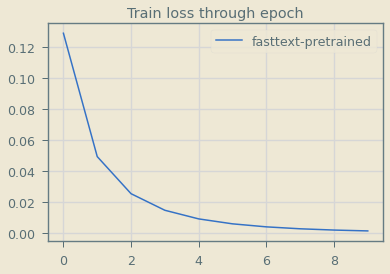

In [115]:
plt.title("Train loss through epoch")
plt.plot(pretrained_losses, label='fasttext-pretrained')

plt.legend()
plt.grid()
plt.show()

## Note

위의 plot 을 보면 fasttext 를 통한 pre-training 이 loss 수렴에 positive effect 를 줌을 볼 수 있다. 이를 통해, fasttext+augmentation 방법론은 각 feature embedding 에 효과적이라고 볼 수 있다.

____

# Trained vector analysis
- test querying
- visualization

### test querying
- 모델 학습에 따른, 변화를 {ingredient:symptom} pair 의 top10 candidates 변화로 체크해본다.
- 또한, 정량적인 performance measure 의 일종으로 pair 의 frequeny rank 를 같이 본다. (자세한 내용은 아래의 Note 참고)

In [116]:
query_ingredient_nm = ingre_w2v.wv.index_to_key[2]
query_ingredient_nm

'아세트아미노펜'

In [117]:
ingre_symp_pair_series = prep_df[prep_df.splitted_ingredient.map(lambda x : query_ingredient_nm in x)].splitted_symptom.values
count_arr = np.unique(np.concatenate(ingre_symp_pair_series), return_counts=True)
rank_dict = {word:(rank/len(count_arr[0])) * 100 for rank,word in enumerate(count_arr[0][np.argsort(-count_arr[1])])}

In [119]:
topn = 10
projected = net.encoder1(torch.tensor(ingre_lemma_dict[query_ingredient_nm])).type(torch.FloatTensor)
cossim_arr = cosine_similarity(net.encoder2.weight.data.numpy(), projected.data.numpy().reshape(1, -1)).reshape(-1)
reversed_symp_lemma_dict = {v:k for k,v in symp_lemma_dict.items()}

results = sorted([(reversed_symp_lemma_dict[i], cossim_arr[i]) for i in np.argsort(cossim_arr)[-topn:]], reverse=True, key=lambda x : x[1])
results[:10]

[('염좌통과 치통', 0.9999858972768985),
 ('구루병의 예방과 아연의 보급', 0.9999684478477239),
 ('임신수유기 등의 경우의 영양보급', 0.9999675227873868),
 ('만성 간질환', 0.9999654260358053),
 ('위장장해', 0.9999636145922439),
 ('타박통', 0.9999630190675296),
 ('견통', 0.9999615954223916),
 ('영양장해', 0.9999612328140416),
 ('치통', 0.9999546857011521),
 ('발열시의 해열', 0.9999531142913429)]

In [121]:
mem = list()

for topn in range(10,1000+1,10) : 
    projected = net.encoder1(torch.tensor(ingre_lemma_dict[query_ingredient_nm])).type(torch.FloatTensor)
    cossim_arr = cosine_similarity(net.encoder2.weight.data.numpy(), projected.data.numpy().reshape(1, -1)).reshape(-1)
    reversed_symp_lemma_dict = {v:k for k,v in symp_lemma_dict.items()}

    results = sorted([(reversed_symp_lemma_dict[i], cossim_arr[i]) for i in np.argsort(cossim_arr)[-topn:]], reverse=True, key=lambda x : x[1])

    pred = np.nanmean([np.nan if rank_dict.get(i[0]) is None else rank_dict.get(i[0]) for i in results ])
    true = topn/len(ingre_w2v.wv.index_to_key) * 100
    mem.append((pred, true))

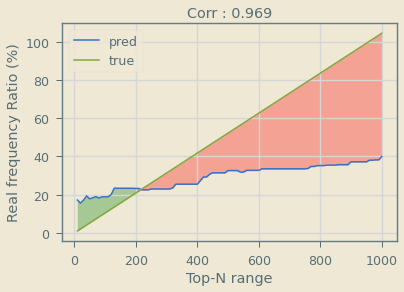

In [122]:
corr_= np.round(np.corrcoef(np.array(mem).T)[0,1], 3)
topn_range = range(10,1000+1,10)
pred = list(map(lambda x : x[0], mem))
true = list(map(lambda x : x[1], mem))
cross_over_index = np.where(np.array(true) > np.array(pred))[0].min()

plt.title('Corr : {}'.format(corr_))
plt.xlabel("Top-N range")
plt.ylabel("Real frequency Ratio (%)")

plt.plot(topn_range, pred, label='pred')
plt.plot(topn_range, true, label='true')

plt.fill_between(topn_range[:cross_over_index], pred[:cross_over_index], true[:cross_over_index], color='green', alpha=0.3)
plt.fill_between(topn_range[cross_over_index:], pred[cross_over_index:], true[cross_over_index:], color='red', alpha=0.3)

plt.grid()
plt.legend()
plt.show()

## Note

위의 값이 나타내는 것은, 전체 symptom feature 의 단어 갯수 N개 있고, 코사인 유사도로 뽑은 단어 C개가 실제 {ingredient:symptom} pair 상에서 Y% 랭크에 드는 단어들이며, 만약 vector 가 frequency 를 완전히 대표한다면 true 값 C/N 과 일치해야 한다. 따라서, 완전히 일치하게 만드는 것이 목표는 아니며, 경향성을 보는 정도의 지표로 사용가능하다. 

위의 plot 을 보면, frequency 지표 true 와 pred 가 차이가 correlation 은 높지만, 값의 차이가 유의하게 존재하며, 이는 vector embedding 을 통한 효과라고 해석될 수 있다. 즉, 데이터 상의 빈도는 작지만, symptom 간 또는 ingredient 간의 유사도에 따라, pair 로 잡히는 결과에 따른 것이다.

_____

### visualization
- T-SNE 알고리즘 사용하였다.
- fasttext 알고리즘이 가지고 있는, word frequency 에 따라 vector norm 이 커지는 경향이 fine-tuning 이후, 거의 사라진다.

In [124]:
finetuned_ingre_vec = net.encoder1.weight.data.numpy()
projected_finetuned_ingre_vec = net.encoder1.weight.type(torch.FloatTensor).data.numpy()
finetuned_symp_vec = net.encoder2.weight.data.numpy()

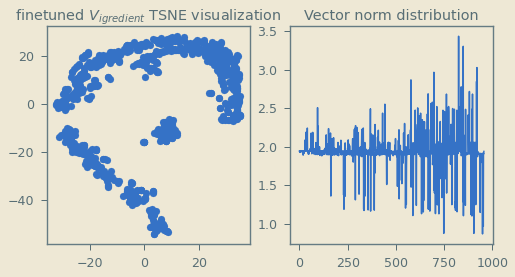

In [125]:
tsne_emb = TSNE(2).fit_transform(finetuned_ingre_vec)

fig, axs = plt.subplots(1,2, figsize=(8,4))

axs[0].set_title("finetuned $V_{igredient}$ TSNE visualization")
axs[0].scatter(tsne_emb[:,0], tsne_emb[:,1])

axs[1].set_title('Vector norm distribution')
axs[1].plot(np.linalg.norm(finetuned_ingre_vec, axis=1))

plt.show()

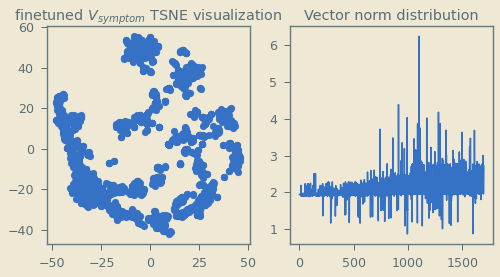

In [127]:
tsne_emb = TSNE(2).fit_transform(finetuned_symp_vec)

fig, axs = plt.subplots(1,2, figsize=(8,4))

axs[0].set_title("finetuned $V_{symptom}$ TSNE visualization")
axs[0].scatter(tsne_emb[:,0], tsne_emb[:,1])

axs[1].set_title('Vector norm distribution')
axs[1].plot(np.linalg.norm(finetuned_symp_vec, axis=1))

plt.show()

_____

## Merge vector to build medicine vector

In [128]:
symptom_vector = np.full(shape=(prep_df.shape[0], symptom_w2v.wv.vector_size), fill_value=np.nan)

for idx, ls in tqdm(enumerate(prep_df.splitted_symptom.values), total=len(prep_df)) : 
    wc = 0
    vector = np.zeros(shape=(symptom_w2v.wv.vector_size,))
    
    for word in ls : 
        wi = symp_lemma_dict.get(word)
        if wi is not None : 
            wv = finetuned_symp_vec[wi]
        else : 
            continue
        wc += 1
        vector += wv
    vector /= wc
    symptom_vector[idx] = vector

  0%|          | 0/4470 [00:00<?, ?it/s]

In [129]:
ingredient_vector = np.full(shape=(prep_df.shape[0], ingre_w2v.wv.vector_size), fill_value=np.nan)

for idx, ls in tqdm(enumerate(prep_df.splitted_ingredient.values), total=len(prep_df)) : 
    wc = 0
    vector = np.zeros(shape=(ingre_w2v.wv.vector_size,))

    for word in ls : 
        wi = ingre_lemma_dict.get(word)
        if wi is not None : 
            wv = finetuned_ingre_vec[wi]
        else : 
            continue
#         wv = symptom_w2v.wv.get_vector(word)
        wc += 1
        vector += wv
    vector /= wc
    ingredient_vector[idx] = vector

  0%|          | 0/4470 [00:00<?, ?it/s]

In [130]:
caution_vector = np.full(shape=(prep_df.shape[0], caut_w2v.wv.vector_size), fill_value=0.)

for idx, ls in tqdm(enumerate(prep_df.tokenized_caution.values), total=len(prep_df)) : 
    wc = 0
    vector = np.zeros(shape=(caut_w2v.wv.vector_size,))
    
    for word in ls : 
        wv = caut_w2v.wv.get_vector(word)
        wc += 1
        vector += wv
    if wc == 0 :
        print("There was no word at {}th row!".format(idx))
    else : 
        vector /= wc
        caution_vector[idx] = vector

  0%|          | 0/4470 [00:00<?, ?it/s]

There was no word at 3th row!
There was no word at 18th row!
There was no word at 105th row!
There was no word at 124th row!
There was no word at 134th row!
There was no word at 135th row!
There was no word at 3094th row!
There was no word at 3270th row!


___

## Vector Stats check before concatenate

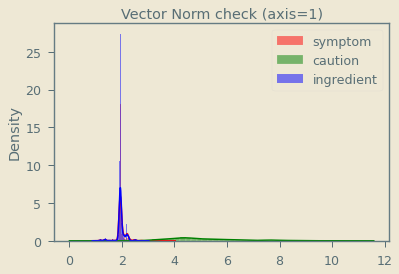

In [131]:
plt.title("Vector Norm check (axis=1)")
sns.histplot(np.linalg.norm(symptom_vector, axis=1), label='symptom', stat='density', color='red', alpha=0.5, kde=True)
sns.histplot(np.linalg.norm(caution_vector, axis=1), label='caution', stat='density', color='green', alpha=0.5, kde=True)
sns.histplot(np.linalg.norm(ingredient_vector, axis=1), label='ingredient', stat='density', color='blue', alpha=0.5, kde=True)

plt.legend()
plt.show()

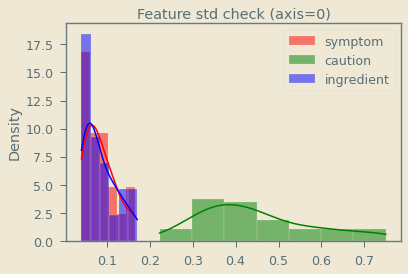

In [132]:
plt.title("Feature std check (axis=0)")

sns.histplot(np.std(symptom_vector, axis=0), label='symptom', stat='density', color='red', alpha=0.5, kde=True)
sns.histplot(np.std(caution_vector, axis=0), label='caution', stat='density', color='green', alpha=0.5, kde=True)
sns.histplot(np.std(ingredient_vector, axis=0), label='ingredient', stat='density', color='blue', alpha=0.5, kde=True)

plt.legend()
plt.show()

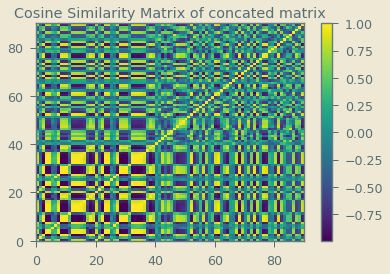

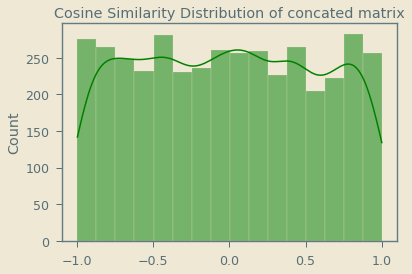

In [133]:
cossim_mat = cosine_similarity(np.hstack([normalize(symptom_vector), normalize(ingredient_vector), normalize(caution_vector)]).T)

plt.title("Cosine Similarity Matrix of concated matrix")
plt.pcolor(cossim_mat)
plt.colorbar()
plt.show()

plt.title("Cosine Similarity Distribution of concated matrix")
cossim_mat[np.tril_indices_from(cossim_mat)] = np.nan
sns.histplot(cossim_mat[np.isfinite(cossim_mat)], kde=True, color='green')
plt.show()

___

# Concat & Cluster

In [134]:
stacked_vector = np.hstack([normalize(symptom_vector),
                            normalize(ingredient_vector), normalize(caution_vector)])

In [135]:
U, S, Vt = np.linalg.svd(stacked_vector-np.mean(stacked_vector, 0))

cumul_var_ratio = np.cumsum((S**2)/np.sum(S**2))
truncate_idx = np.where(cumul_var_ratio > 0.9)[0].min()
truncate_idx

11

In [136]:
reduced_emb = np.dot(stacked_vector - np.mean(stacked_vector, 0), Vt[:truncate_idx].T)

In [137]:
ncl = 1000 # determined by silhouette score
label = AgglomerativeClustering(ncl).fit_predict(normalize(reduced_emb))

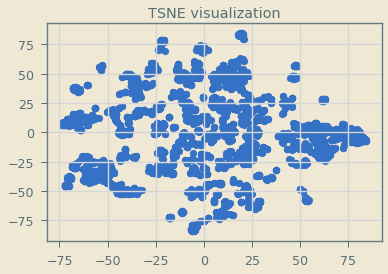

In [138]:
tsne_emb = TSNE(2).fit_transform(reduced_emb)

plt.title("TSNE visualization")
plt.scatter(tsne_emb[:,0], tsne_emb[:,1])
plt.grid()
plt.show()

In [139]:
def calc_cossim_arr(x) : 
    cossim_arr = cosine_similarity(x)
    cossim_arr[np.tril_indices_from(cossim_arr)] = np.nan
    return np.nanmean(cossim_arr)

In [140]:
vis_cnt = 5
cnt = 0

for l in np.unique(label) :
    bool_ = label == l    
    allocated_df = prep_df.loc[bool_].iloc[:, [0,1,2,3,4]]
    
    if allocated_df.shape[0] == 1 : 
        continue
    
    display(allocated_df.head(3)) # only looks 3 of them
    display(Markdown("_________"))
    
    cnt += 1
    if cnt > vis_cnt : 
        break

,itemname,entpname,ingredient,symptom,caution
1041,하드칼츄어블정,부광약품(주),"농축콜레칼시페롤과립,탄산칼슘","칼슘 결핍 및 기타 칼슘의 보급과 임신,수유기, 발육기, 노년기의 비타민 D의 보급...",이 약에 과민증 환자 고칼슘혈증 유육종증 신질환 만12개월 미만의 젖먹이 신장...
1479,디카맥스1000정,(주)다림바이오텍,"탄산칼슘95%과립,농축콜레칼시페롤과립","임신,수유기, 발육기, 노년기의 비타민 D의 보급과 뼈, 이의 발육불량, 구루병의 ...",이 약에 과민증 환자 고칼슘혈증 유육종증 신장질환 만 12개월 미만의 젖먹이 ...
1556,카비드츄어블정,(주)셀트리온제약,"농축콜레칼시페롤분말,탄산칼슘","임신,수유기, 발육기, 노년기의 비타민 D의 보급과 뼈, 이의 발육불량, 구루병의 ...",이 약에 과민증 환자 고칼슘혈증 유육종증 신장질환 만 12개월 미만의 젖먹이 ...


_________

,itemname,entpname,ingredient,symptom,caution
100,바로론정(클로닉신리시네이트),국제약품(주),클로닉신리시네이트,"근육통, 신경통, 외상후 및 수술후 통증, 두통, 치통, 귀통증의 경증 또는 중등도...",소화성궤양 환자 약물에 기인하여 위 십이지장에 동요 발현 이 약에 과민증 환자 아...
149,크로낙정(클로닉신리시네이트),영일제약(주),클로닉신리시네이트,"근육통, 신경통, 외상후 및 수술후 통증, 두통, 치통, 귀통증의 경증 또는 중등도...",소화성궤양 환자 약물에 기인하여 위 십이지장에 동요 발현시 이 약에 과민증 환자...
164,디크로닉정(클로닉신리시네이트),대화제약(주),클로닉신리시네이트,"근육통, 신경통, 외상후 및 수술후 통증, 두통, 치통, 귀통증의 경증 또는 중등도...",소화성궤양 환자 약물에 기인하여 위 십이지장에 동요 발현시 이 약에 과민증 환자...


_________

,itemname,entpname,ingredient,symptom,caution
399,삼남아세트아미노펜정,삼남제약(주),아세트아미노펜,"감기로 인한 발열 및 동통, 두통, 신경통, 근육통, 월경통, 염좌통과 치통, 관절...",이 약에 과민증 환자 소화성 궤양 심한 혈액이상 심한 간장애 심한 신장장애 ...
418,트라몰정325밀리그람(아세트아미노펜),코오롱제약(주),아세트아미노펜,"감기로 인한 발열 및 동통, 두통, 신경통, 근육통, 월경통, 염좌통과 치통, 관절...",이 약에 과민증 환자 소화성궤양 심한 혈액이상 환자 심한 간장애 심한 콩팥장...
469,루트펜325밀리그램정(아세트아미노펜),(주)바이넥스,아세트아미노펜,"감기로 인한 발열 및 동통, 두통, 신경통, 근육통, 월경통, 염좌통과 치통, 관절...",이 약에 과민증 환자 소화성궤양 심한 혈액이상 환자 심한 간장애 심한 콩팥장...


_________

,itemname,entpname,ingredient,symptom,caution
944,트리겔정,대원제약(주),"탄산마그네슘,건조수산화알루미늄겔,옥세타자인","위산과다, 속쓰림, 위부불쾌감, 위부팽만감, 체함, 구역, 구토, 위통, 신트림",이 약에 과민증 환자 투석요법을 받고 있는 사람 고마그네슘혈증 고인산혈증 변...
1020,포리겔정,(주)마더스제약,"탄산마그네슘,옥세타자인,건조수산화알루미늄겔","위산과다, 속쓰림, 위부불쾌감, 위부팽만감, 체함, 구역, 구토, 위통, 신트림",이 약에 과민증 환자 투석 요법을 받고 있는 환자 고마그네슘혈증 고인산혈증 변비...
3275,프리번정,(주)중헌제약,"탄산마그네슘,건조수산화알루미늄겔,옥세타자인","위산과다, 속쓰림, 위부불쾌감, 위부팽만감, 체함, 구역, 구토, 위통, 신트림",이 약에 과민증 환자 투석요법을 받고 있는 사람 고마그네슘혈증 고인산혈증 변...


_________

,itemname,entpname,ingredient,symptom,caution
209,젠텔정400밀리그람(알벤다졸),(주)유한양행,알벤다졸,"회충, 요충, 십이지장충, 편충, 아메리카 구충, 분선충의 감염 및 이들 혼합감염의 치료",이 약에 과민증 환자 임부 및 임신하고 있을 가능성이 있는 여성 및 수유부 2세 ...
210,버미플루정(플루벤다졸),신풍제약(주),플루벤다졸,"회충, 요충, 편충, 십이지장충의 감염 및 이들 혼합감염의 치료",이 약에 과민증 환자 임부는 이 약을 복용하지 마십시오 이 약을 복용하기 전에1세...
213,젤콤정(플루벤다졸),(주)종근당,플루벤다졸,"회충, 요충, 편충, 십이지장충의 감염 및 이들 혼합감염의 치료",이 약에 과민증 환자 임부는 이 약을 복용하지 마십시오 이 약을 복용하기 전에1세...


_________

,itemname,entpname,ingredient,symptom,caution
0,활명수,동화약품(주),"건강,육두구,후박,진피,창출,현호색,L-멘톨,육계,정향,아선약,고추틴크","식욕감퇴, 위부팽만감, 소화불량, 과식, 체함, 구역, 구토",만 3개월 미만의 젖먹이는 이 약을 복용하지 마십시오 이 약을 복용하기 전에만 1세...
685,까스명수에프액,삼성제약(주),"건강,육두구,후박,진피,창출,현호색,L-멘톨,육계,정향,아선약,고추틴크","식욕감퇴, 위부팽만감, 소화불량, 과식, 체함, 구역, 구토",만 3개월 미만의 젖먹이는 이 약을 복용하지 마십시오 이 약을 복용하기 전에만 1세...
1933,베나치오액,동아제약(주),"감초,건강,진피,창출,현호색,L-멘톨,육계,회향","식욕감퇴, 위부팽만감, 소화불량, 과식, 체함, 구역, 구토",만 3개월 미만의 젖먹이는 이 약을 복용하지 마십시오 이 약을 복용하기 전에임부 또...


_________

In [141]:
mem = list()

for l in np.unique(label) :
    bool_ = label == l

    allocated_iv = ingredient_vector[bool_].copy()
    allocated_sv = symptom_vector[bool_].copy()
    allocated_cv = caution_vector[bool_].copy()
    
    if allocated_iv.shape[0] <= 1 : 
        continue

    ic, sc, cc = map(lambda x : np.round(calc_cossim_arr(x),3), [allocated_iv, allocated_sv, allocated_cv])
    mem.append((ic, sc, cc))

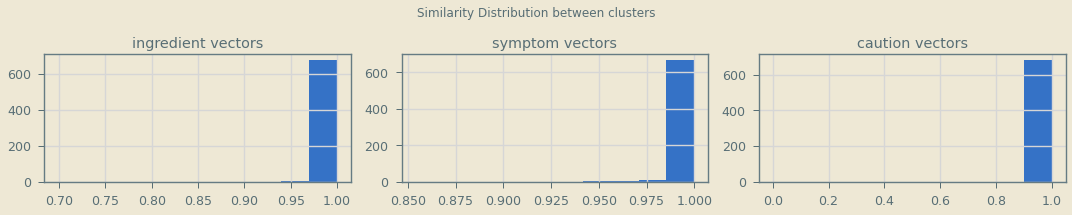

In [142]:
fig, axs = plt.subplots(1,3, figsize=(15,3))
flattened_axs = axs.ravel()

fig.suptitle("Similarity Distribution between clusters")
for fn, idx in zip(['ingredient', 'symptom', 'caution'], range(len(mem[0]))) : 
    flattened_axs[idx].set_title("{} vectors".format(fn))
    flattened_axs[idx].hist(list(map(lambda x : x[idx], mem)), bins=10)
    flattened_axs[idx].grid()
fig.tight_layout()
fig.show()

___

# Test 1

In [143]:
iv = ingredient_vector.copy()
sv = symptom_vector.copy()
cv = caution_vector.copy()

cossim_iv = cosine_similarity(iv)
cossim_sv = cosine_similarity(sv)
cossim_cv = cosine_similarity(cv)

cossim_iv[np.tril_indices_from(cossim_iv)] = np.nan
cossim_sv[np.tril_indices_from(cossim_sv)] = np.nan
cossim_cv[np.tril_indices_from(cossim_cv)] = np.nan

cossim_iv_vec = cossim_iv[np.isfinite(cossim_iv)]
cossim_sv_vec = cossim_sv[np.isfinite(cossim_sv)]
cossim_cv_vec = cossim_cv[np.isfinite(cossim_cv)]

In [144]:
mem = list()

for _ in tqdm(range(100)) : 
    sampled_idx = np.random.choice(np.arange(cossim_iv_vec.shape[0]), 1000, replace=False)
    sampled_cossim_iv_vec, sampled_cossim_sv_vec, sampled_cossim_cv_vec = \
    cossim_iv_vec[sampled_idx], cossim_sv_vec[sampled_idx], cossim_cv_vec[sampled_idx]
    sampled_correl_mat = np.corrcoef([sampled_cossim_iv_vec, sampled_cossim_sv_vec, sampled_cossim_cv_vec])
    mem.append(sampled_correl_mat)

  0%|          | 0/100 [00:00<?, ?it/s]

In [145]:
samples = np.nan_to_num(np.stack(mem))
std_ = samples.std(0)/samples.shape[0]
mean_ = samples.mean(0)
z = 1.96

In [146]:
display(Markdown("### Lower confidence interval of correlation"))
display(pd.DataFrame(mean_-z*std_, index=['ingredient', 'symptom', 'caution'],
            columns=['ingredient', 'symptom', 'caution']))

display(Markdown("### Higher confidence interval of correlation"))
display(pd.DataFrame(mean_+z*std_, index=['ingredient', 'symptom', 'caution'],
            columns=['ingredient', 'symptom', 'caution']))

### Lower confidence interval of correlation

,ingredient,symptom,caution
ingredient,1.000000,0.712135,0.017688
symptom,0.712135,1.000000,0.047362
caution,0.017688,0.047362,1.000000


### Higher confidence interval of correlation

,ingredient,symptom,caution
ingredient,1.000000,0.713681,0.019320
symptom,0.713681,1.000000,0.048777
caution,0.019320,0.048777,1.000000


# Note

[project 1](https://github.com/hskimim/medicine2vec/blob/master/clustering.ipynb) 과 비교했을 때, correlation 이 1.5배에서 2배정도로 상승한 것을 볼 수 있다. 흥미로운 점은, 모델 학습에 사용되지 않은 caution feature 의 correlation 또한 증가한 것이다.

____

## Test 2

In [147]:
def stat_test(vec, iters=30) : 
    cossim_symptom = cosine_similarity(vec[bool_])
    cossim_symptom[np.tril_indices_from(cossim_symptom)] = np.nan
    null_sim = np.nanmean(cossim_symptom)
    
    alternative_sim = 0
    for i in range(iters) : 
        cossim_symptom = cosine_similarity(vec[not_index_])
        cossim_symptom[np.tril_indices_from(cossim_symptom)] = np.nan
        alternative_sim += np.nanmean(cossim_symptom)
        
    return null_sim, alternative_sim/iters

In [148]:
nm_ls, vec_ls = ['ingredient', 'symptom', 'caution'], [ingredient_vector, symptom_vector, caution_vector]
ncl = 500 # arbitrarily determined

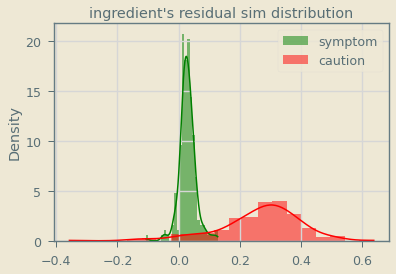

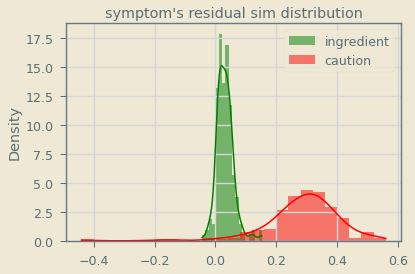

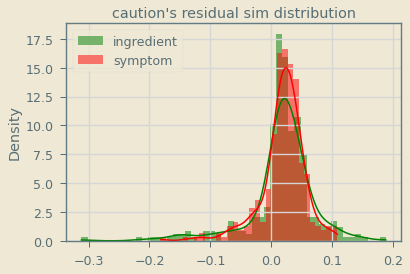

In [149]:
for idx in range(len(nm_ls)) : 
    
    stacked_vector = normalize(vec_ls[idx])
    U, S, Vt = np.linalg.svd(stacked_vector-np.mean(stacked_vector, 0))

    cumul_var_ratio = np.cumsum((S**2)/np.sum(S**2))
    truncate_idx = np.where(cumul_var_ratio > 0.9)[0].min()
    reduced_emb = np.dot(stacked_vector - np.mean(stacked_vector, 0), Vt[:truncate_idx].T)
    
    label = AgglomerativeClustering(ncl).fit_predict(normalize(reduced_emb))

    alt_ls1, alt_ls2 = list(), list()
    not_target_index = np.arange(len(nm_ls))[~np.in1d(np.arange(len(nm_ls)), idx)]
    
    for l in np.unique(label) :    
        bool_ = label == l
        if bool_.sum() < 5 : 
            continue
        not_index_ = np.random.choice(np.where(~bool_)[0], bool_.sum(), replace=False)

        null_alt1,alternative_alt1 = stat_test(vec_ls[not_target_index[0]])
        null_alt2,alternative_alt2 = stat_test(vec_ls[not_target_index[1]])

        diff1 = null_alt1 - alternative_alt1
        diff2 = null_alt2 - alternative_alt2

        alt_ls1.append(diff1)
        alt_ls2.append(diff2)

    sns.histplot(alt_ls1, color="green", label=nm_ls[not_target_index[0]], kde=True, stat="density", linewidth=0)
    sns.histplot(alt_ls2, color="red", label=nm_ls[not_target_index[1]], kde=True, stat="density", linewidth=0)
    
    plt.title("{}'s residual sim distribution".format(nm_ls[idx]))
    plt.grid()
    plt.legend()
    plt.show()

# Note

흥미로운 부분을 발견하였는데, 위에서 진행한 모델링은 ingredient vector 를 projection 을 통해, symptom vector 를 닮아가게 한 것이다. 이 때문인지, symptom 을 clustering 해서 본 ingredient feature 의 discrimination power 가 상승한 것을 확인할 수 있었다. 하지만, 이에 반해, 그 반대의 경우는 performance 가 줄어들었다. [[비교]](https://github.com/hskimim/medicine2vec/blob/master/clustering.ipynb)

이에 따라, ingredient $\rightarrow$ symptom 와 symptom $\rightarrow$ ingredient 에 대해 양방향 학습을 하게 되면, 좀 더 나은 결과를 기대할 수 있을 지도 모른다.